In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from model import *
from env import GridWorld
import time
import matplotlib.pyplot as plt
from PIL import Image
import os

# Learning Virus Mitigation Strategies Under Pro-Social Incentives
*************

## Training
*************

### Baseline: Learning Strictly Pro-Social Behavior (No Communication)

In [9]:
env = GridWorld(dim_x=16, dim_y=16, n_agents=80, n_iter=100, initial_infections=0, prox_incent=0, num_incent=1, len_incent=1, torodial=True)
actor_model = ActorModel()
critic_model = CriticModel()

In [13]:
def simulate(env, actor_model, save_name=None, comm=False):
    if (save_name is not None) and (os.path.exists(f'images/{save_name}') is False):
        os.makedirs(f'images/{save_name}')
    env.reset()
    actor_model.eval()
    done, i = False, 1
    while not done:
        im = env.render()
        if save_name is not None:
            Image.fromarray(im).save(f'images/{save_name}/anim_{i}.png')
        i += 1
        for a in range(env.n_agents):
            obs = env.observe(a)
            if comm:
                act, c = actor_model(torch.Tensor([obs]))
                act = actor_model.sample_move(act)[0]
                c = c.detach().numpy()
                env.step(act, a, c)
            else:
                act = actor_model.sample_move(actor_model(torch.Tensor([obs])))[0]
                env.step(act, a)
        done = env.timestep()
        time.sleep(0.025)
    env.close()
    
# demo before training
simulate(env, actor_model)

In [11]:
hist = train(env, actor_model, critic_model, '1', episodes=100, replay_bank_size=15, updates_per_epoch=160)

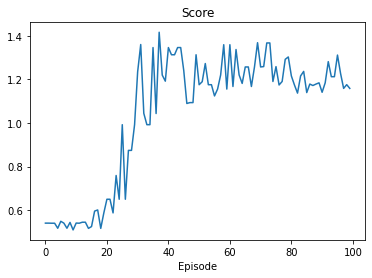

In [12]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [14]:
actor_model = torch.load('models/1_actor.torch')
critic_model = torch.load('models/1_critic.torch')

In [15]:
# save demo after training
simulate(env, actor_model, save_name='1')

### Baseline: Learning Strictly Anti-Social Behavior (No Communication)

In [7]:
env = GridWorld(dim_x=16, dim_y=16, n_agents=150, n_iter=40, initial_infections=10, prox_incent=0, num_incent=0, len_incent=0)
actor_model = ActorModel()
critic_model = CriticModel()

In [ ]:
hist = train(env, actor_model, critic_model, '2', episodes=150, replay_bank_size=30, updates_per_epoch=300)

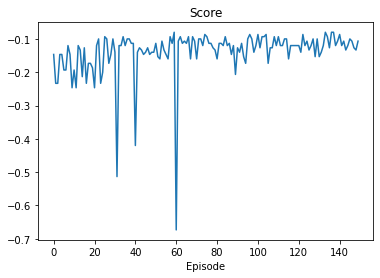

In [25]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [16]:
actor_model = torch.load('models/2_actor.torch')
critic_model = torch.load('models/2_critic.torch')

In [17]:
# save demo after training
simulate(env, actor_model, save_name='2')

### Learning Virus Management with Central Objective (No Communication)

In [56]:
env = GridWorld(dim_x=18, dim_y=18, n_agents=100, n_iter=100, initial_infections=5, prox_incent=1, num_incent=0, len_incent=0)
actor_model = ActorModel()
critic_model = CriticModel()

In [57]:
hist = train(env, actor_model, critic_model, '3', episodes=300, replay_bank_size=25, updates_per_epoch=200)

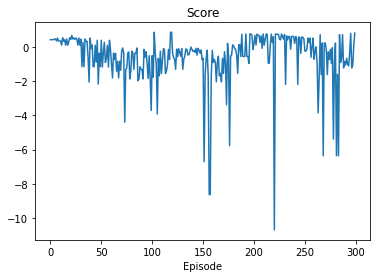

In [58]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [18]:
actor_model = torch.load('models/3_actor.torch')
critic_model = torch.load('models/3_critic.torch')

In [19]:
# save demo after training
simulate(env, actor_model, save_name='3')

### Learning Virus Management with Number of Distinct Interactions Incentive (No Communication)

In [16]:
env = GridWorld(dim_x=18, dim_y=18, n_agents=150, n_iter=100, initial_infections=5, prox_incent=0, num_incent=2, len_incent=0, torodial=True)
actor_model = ActorModel()
critic_model = CriticModel()

In [18]:
hist = train(env, actor_model, critic_model, '4', episodes=300, replay_bank_size=20, updates_per_epoch=300)

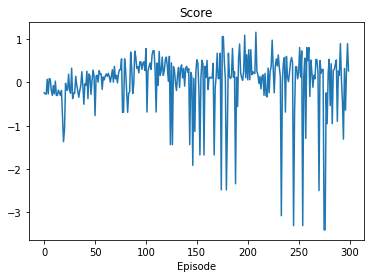

In [19]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [17]:
actor_model = torch.load('models/4_actor.torch')
critic_model = torch.load('models/4_critic.torch')

In [19]:
# save demo after training
simulate(env, actor_model, save_name='4')

### Learning Virus Management with Central Objective (Communication)

In [75]:
env = GridWorld(dim_x=18, dim_y=18, n_agents=100, n_iter=100, initial_infections=5, prox_incent=1, num_incent=0, len_incent=0, communication_layers=3)
actor_model = ActorModel(comm_layers=3)
critic_model = CriticModel(comm_layers=3)

In [67]:
hist = train(env, actor_model, critic_model, '5', episodes=400, replay_bank_size=25, updates_per_epoch=200)

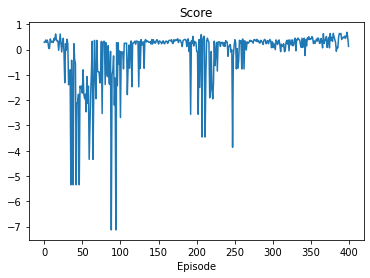

In [68]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [76]:
actor_model = torch.load('models/5_actor.torch')
critic_model = torch.load('models/5_critic.torch')

In [77]:
# save demo after training
simulate(env, actor_model, save_name='5', comm=True)

### Learning Virus Management with Number of Distinct Interactions Incentive (Communication)

In [13]:
env = GridWorld(dim_x=18, dim_y=18, n_agents=150, n_iter=100, initial_infections=3, prox_incent=0, num_incent=2, len_incent=0, communication_layers=3, torodial=True)
actor_model = ActorModel(comm_layers=3)
critic_model = CriticModel(comm_layers=3)

In [4]:
hist = train(env, actor_model, critic_model, '6', episodes=300, replay_bank_size=25, updates_per_epoch=300)

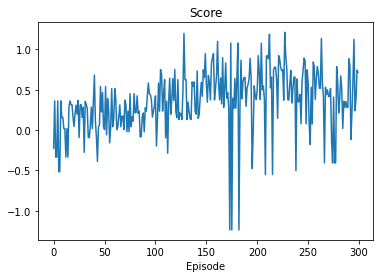

In [5]:
plt.plot(hist)
plt.title('Score')
plt.xlabel('Episode')
plt.show()

In [14]:
actor_model = torch.load('models/6_actor.torch')
critic_model = torch.load('models/6_critic.torch')

In [15]:
# save demo after training
simulate(env, actor_model, save_name='6', comm=True)

## Evaluating Behaviors
*****************

### Communication vs No Communication: Central Objective

In [24]:
def evaluate(env, model, comm=False, n_iter=50):
    scores = []
    model.eval()
    for _ in range(n_iter):
        env.reset()
        done = False
        while not done:
            for a in range(env.n_agents):
                obs = env.observe(a)
                if comm:
                    act, c = model(torch.Tensor([obs]))
                    act = model.sample_move(act)[0]
                    c = c.detach().numpy()
                    env.step(act, a, c)
                else:
                    act = model.sample_move(model(torch.Tensor([obs])))[0]
                    env.step(act, a)
            done = env.timestep()
        scores.append(env.score().mean())
    return np.array(scores)

In [25]:
no_comm = torch.load('models/3_actor.torch')
no_comm_env = GridWorld(dim_x=18, dim_y=18, n_agents=100, n_iter=100, initial_infections=5, prox_incent=1, num_incent=0, len_incent=0)
no_comm_scores = evaluate(no_comm_env, no_comm)

comm = torch.load('models/5_actor.torch')
comm_env = GridWorld(dim_x=18, dim_y=18, n_agents=100, n_iter=100, initial_infections=5, prox_incent=1, num_incent=0, len_incent=0, communication_layers=3)
comm_scores = evaluate(comm_env, comm, comm=True)

diff = comm_scores - no_comm_scores
print("mean score diff: ",diff.mean())
print("std score diff: ",diff.std())

mean score diff:  0.7687051851851853
std score diff:  1.9357331522551302


### Communication vs No Communication: Number of Distinct Interactions

In [26]:
no_comm = torch.load('models/4_actor.torch')
no_comm_env = GridWorld(dim_x=18, dim_y=18, n_agents=150, n_iter=100, initial_infections=5, prox_incent=0, num_incent=2, len_incent=0, torodial=True)
no_comm_scores = evaluate(no_comm_env, no_comm)

comm = torch.load('models/6_actor.torch')
comm_env = GridWorld(dim_x=18, dim_y=18, n_agents=150, n_iter=100, initial_infections=3, prox_incent=0, num_incent=2, len_incent=0, communication_layers=3, torodial=True)
comm_scores = evaluate(comm_env, comm, comm=True)

diff = comm_scores - no_comm_scores
print("mean score diff: ",diff.mean())
print("std score diff: ",diff.std())

mean score diff:  0.484264888888889
std score diff:  0.9702501335817266


## Analysing Behaviors
***************

### Analysing movement

In [3]:
def maximize_input(model, target, comm=False):
    low_bnd = torch.tensor([[-1,-0.5,-0.5,0,0,0,0,0] + [0 for _ in range(9*(model.comm_layers+1))]])
    up_bnd = torch.tensor([[1,0.5,0.5,1,1,1,1,1] + [0.9 for _ in range(9*(model.comm_layers+1))]])
    
    x = torch.rand(up_bnd.shape)
    x.requires_grad = True
    for _ in range(256):
        if comm:
            _, pred = model(x)
            l = pred[0][target]
        else:
            pred, _ = model(x)
            l = torch.nn.CrossEntropyLoss()(pred, torch.Tensor([target]).long())
        l = l - 0.02*x[0,8:].sum()
        l.backward()
    
        x = x + x.grad
        x = x.detach()
        x = x.clamp(low_bnd, up_bnd)
        x.requires_grad = True
        
    return x.detach().numpy()

def interpret(x, comm_layers=0):
    x = x[0]
    print("Status: "+["succeptible", "symptomatic", "recovered"][round(x[0])])
    print(f"Location: ({x[1]:.1f},{x[2]:.1f})")
    print(f"Time: {x[3]:.1f}")
    print(f"Population Status: {x[4]:.1f}")
    print(f"Contacts Score: {x[5]:.1f}")
    print(f"Distance Score: {x[6]:.1f}")
    print(f"Length Score: {x[7]:.1f}")
    print("Agents:")
    print(np.around(1/(1-x[8:17]) - 1).reshape((3,3)))
    for i in range(comm_layers):
        print(f"Comm Layer {i+1}:")
        print(np.around(x[17+9*i:26+9*i].reshape((3,3))))

In [4]:
model = torch.load('models/6_actor.torch') # interaction number model
target = 4 # stay still

x = maximize_input(model, target)
interpret(x)

Status: symptomatic
Location: (0.2,0.4)
Time: 0.2
Population Status: 1.0
Contacts Score: 0.1
Distance Score: 0.5
Length Score: 0.4
Agents:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Analysing communication

In [5]:
model = torch.load('models/6_actor.torch') # interaction number model
target = 0 # comm layer 0

x = maximize_input(model, target, comm=True)
interpret(x, comm_layers=model.comm_layers)

Status: recovered
Location: (0.5,0.2)
Time: 0.0
Population Status: 0.6
Contacts Score: 0.0
Distance Score: 0.0
Length Score: 0.4
Agents:
[[9. 9. 9.]
 [0. 0. 0.]
 [0. 0. 0.]]
Comm Layer 1:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
Comm Layer 2:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Comm Layer 3:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
